# Downsample the WT Gold data to 30 fps

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from disp import set_plot

NTR = 84
FPS_UP = 150
FPS_DN = 30.03
DT_DN = 1/FPS_DN

df_up = pd.read_csv('data/simple/w_song_f_behav_up.csv')
df_up

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,3.005674,2.058972,0.464674,3.970362,2.759047,1.279711
1,0,1,0.006667,1,0,0,0,5.064646,-1.111705,0.591069,3.970362,4.680042,2.024156
2,0,2,0.013333,1,0,0,0,3.952941,-0.108571,0.611765,4.132553,3.268321,2.306095
3,0,3,0.020000,1,0,0,0,3.844370,-0.491905,1.212772,3.438263,4.007411,0.436646
4,0,4,0.026667,1,0,0,0,3.352465,-1.040417,1.327018,0.000000,3.601223,0.176610
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11654473,83,55071,367.140000,1,0,0,0,-0.901992,0.901992,0.660614,2.291984,0.942093,0.602047
11654474,83,55072,367.146667,1,0,0,0,0.000000,-1.117392,0.000000,1.403489,0.000000,0.000000
11654475,83,55073,367.153333,1,0,0,0,-1.117392,1.117392,0.037878,1.403489,1.108938,0.142324
11654476,83,55074,367.160000,1,0,0,0,0.000000,0.000000,0.000000,1.811927,0.000000,0.000000


In [2]:
dfs_tr_up = [df_up[df_up['ID'] == ctr] for ctr in range(NTR)]

In [3]:
# loop over trials and downsample via moving average
dfs_tr_dn = []
for ctr, df_tr_up in enumerate(dfs_tr_up):
    sys.stdout.write('.')
    t_up = np.array(df_tr_up['T'])
    t_max = t_up[-1]
    
    t = np.arange(0, t_max, DT_DN)
    q = np.zeros(len(t), dtype=int)
    s = np.zeros(len(t), dtype=int)
    p = np.zeros(len(t), dtype=int)
    f = np.zeros(len(t), dtype=int)
    
    ffv = np.nan * np.zeros(len(t))
    ffa = np.nan * np.zeros(len(t))
    fls = np.nan * np.zeros(len(t))
    frs = np.nan * np.zeros(len(t))
    fmfv = np.nan * np.zeros(len(t))
    fmls = np.nan * np.zeros(len(t))
    
    for ct, t_start in enumerate(t):
        t_end = t_start + DT_DN
        mt = (t_start <= t_up) & (t_up < t_end)
        
        # get which song mode dominates in this time window
        ct_q = np.sum(df_tr_up['Q'][mt])
        ct_s = np.sum(df_tr_up['S'][mt])
        ct_p = np.sum(df_tr_up['P'][mt])
        ct_f = np.sum(df_tr_up['F'][mt])
        
        if ct_s == 0 and ct_p == 0 and ct_f == 0:
            # only call time point quiet if no sine or pulse at all
            imode = 0
        else:
            # otherwise find dominant mode
            imode = np.argmax([-np.inf, ct_s, ct_p, ct_f])
            
        if imode == 0:
            q[ct] = 1
        elif imode == 1:
            s[ct] = 1
        elif imode == 2:
            p[ct] = 1
        elif imode == 3:
            f[ct] = 1
            
        # take mean of fbehav vars
        ffv[ct] = np.array(df_tr_up['FFV'])[mt].mean()
        ffa[ct] = np.array(df_tr_up['FFA'])[mt].mean()
        fls[ct] = np.array(df_tr_up['FLS'])[mt].mean()
        frs[ct] = np.array(df_tr_up['FRS'])[mt].mean()
        fmfv[ct] = np.array(df_tr_up['FMFV'])[mt].mean()
        fmls[ct] = np.array(df_tr_up['FMLS'])[mt].mean()
        
    df_tr_dn = pd.DataFrame(
        columns=['ID', 'FRAME', 'T', 'Q', 'S', 'P', 'F', 'FFV', 'FFA', 'FLS', 'FRS', 'FMFV', 'FMLS'],
        data={
            'ID': np.repeat(ctr, len(t)),
            'FRAME': np.arange(len(t)),
            'T': t,
            'Q': q,
            'S': s,
            'P': p,
            'F': f,
            'FFV': ffv,
            'FFA': ffa,
            'FLS': fls,
            'FRS': frs,
            'FMFV': fmfv,
            'FMLS': fmls,
        })

    dfs_tr_dn.append(df_tr_dn)

....................................................................................

In [4]:
# concatenate and save dataframes
df_dn = pd.concat(dfs_tr_dn)
df_dn.to_csv('data/simple/w_song_f_behav.csv', index=False)

In [5]:
# load down sampled data and plot atop original
df_dn_reloaded = pd.read_csv('data/simple/w_song_f_behav.csv')
dfs_tr_dn_reloaded = [df_dn_reloaded[df_dn_reloaded['ID'] == ctr] for ctr in range(NTR)]
df_dn_reloaded

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,3.844019,-0.138725,0.841459,3.102308,3.663209,1.244644
1,0,1,0.033300,1,0,0,0,2.645045,0.217158,0.958827,1.644406,2.143699,1.633865
2,0,2,0.066600,1,0,0,0,2.817165,-0.170636,0.799927,0.591572,2.212304,1.895512
3,0,3,0.099900,1,0,0,0,4.238035,0.000825,0.455475,0.842094,3.535255,2.372842
4,0,4,0.133200,1,0,0,0,6.156643,0.280813,0.516347,1.218568,5.392901,2.986841
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2333241,83,11022,367.032967,0,0,0,1,-0.058612,0.000000,0.240739,0.721101,0.063511,0.234946
2333242,83,11023,367.066267,0,0,0,1,0.381769,0.000000,0.156364,0.000000,-0.366270,0.191376
2333243,83,11024,367.099567,0,0,0,1,0.196337,0.000000,0.482724,0.839733,-0.179289,0.481899
2333244,83,11025,367.132867,1,0,0,0,-0.403877,0.000000,0.139698,1.868385,0.410206,0.148874


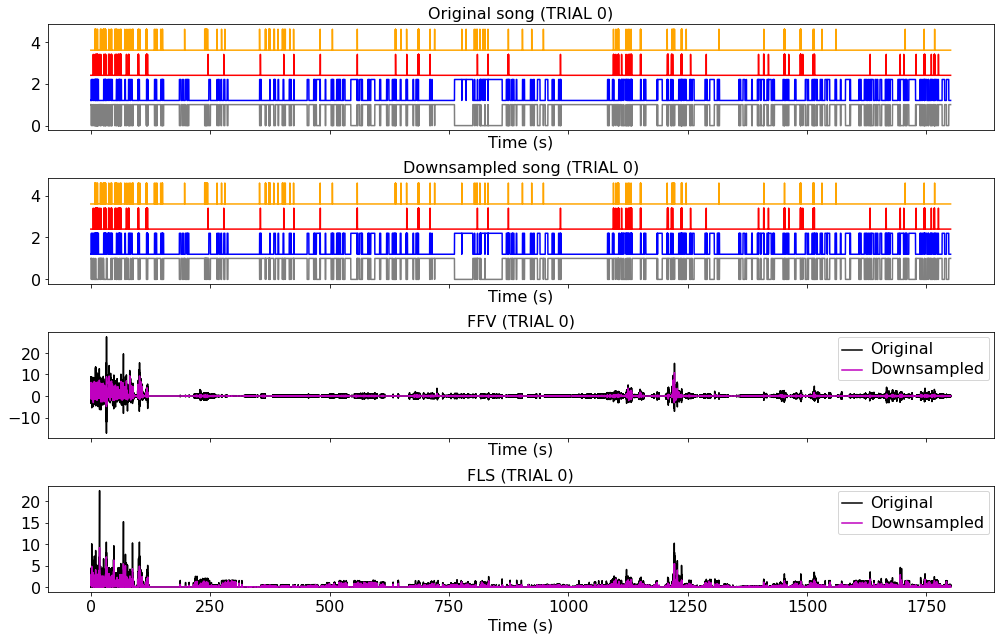

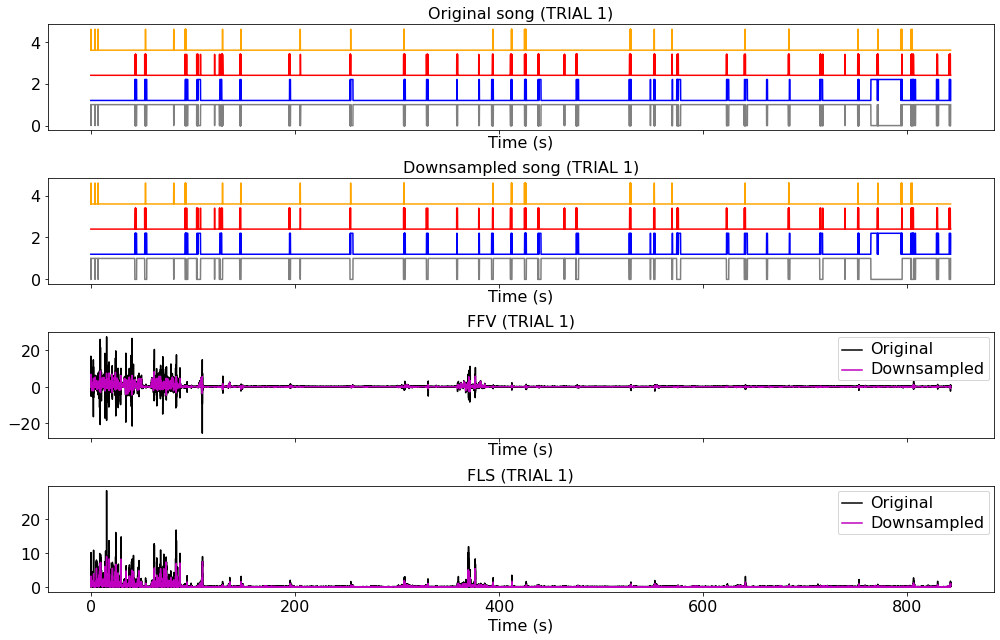

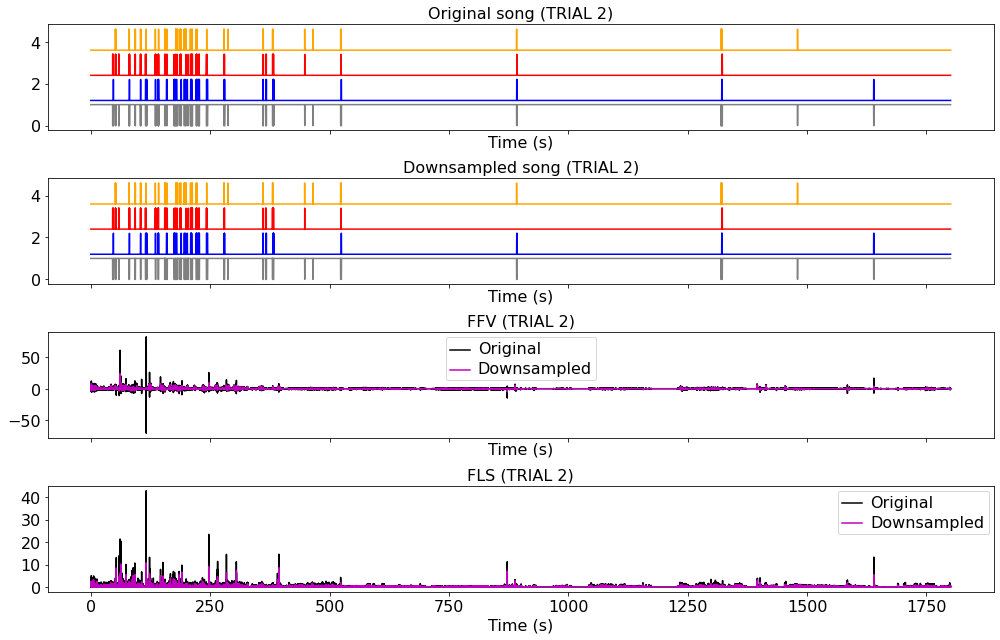

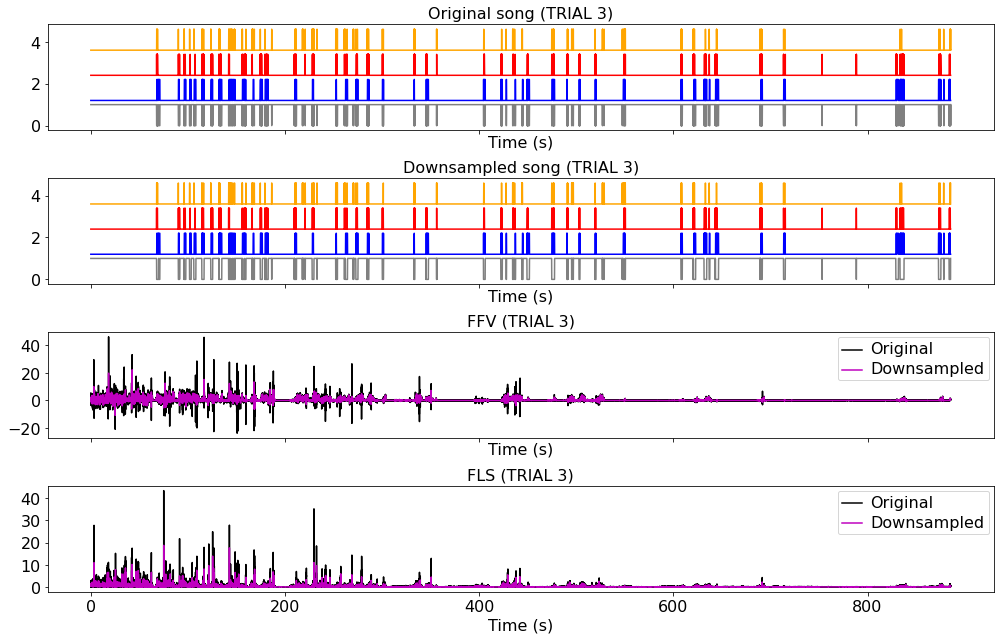

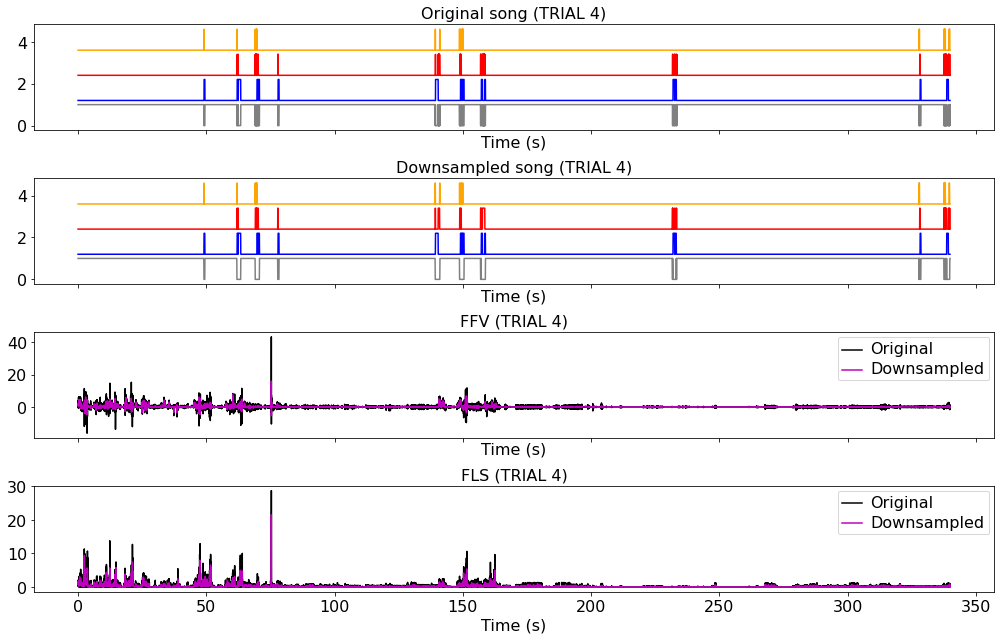

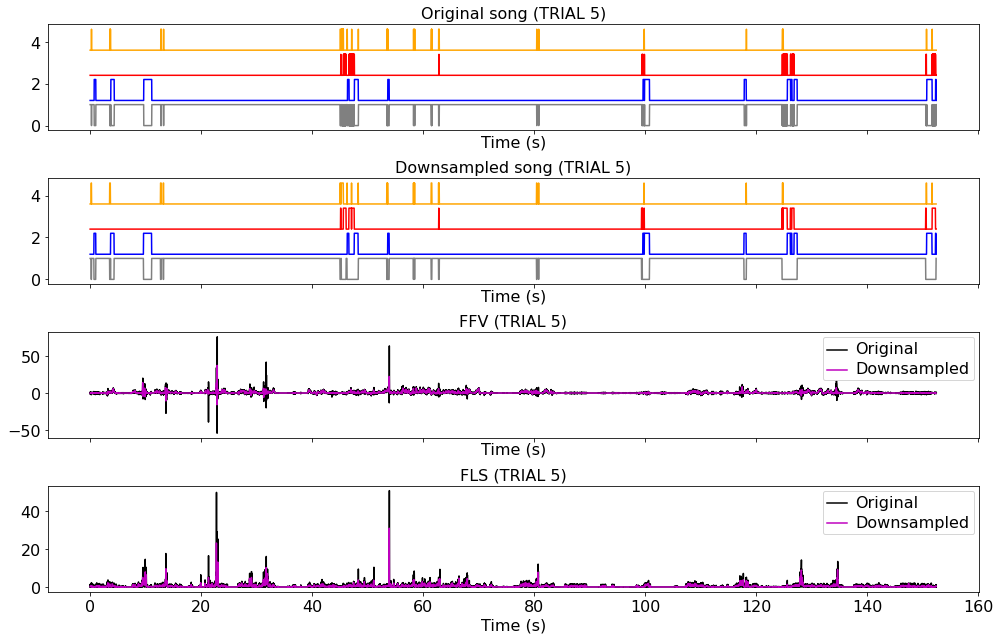

In [6]:
for ctr in range(6):
    fig, axs = plt.subplots(4, 1, figsize=(14, 9), tight_layout=True, sharex=True)
    
    t_up = dfs_tr_up[ctr]['T']
    q_up = dfs_tr_up[ctr]['Q']
    s_up = dfs_tr_up[ctr]['S']
    p_up = dfs_tr_up[ctr]['P']
    f_up = dfs_tr_up[ctr]['F']
    
    ffv_up = dfs_tr_up[ctr]['FFV']
    fls_up = dfs_tr_up[ctr]['FLS']
    
    t_dn = dfs_tr_dn_reloaded[ctr]['T']
    q_dn = dfs_tr_dn_reloaded[ctr]['Q']
    s_dn = dfs_tr_dn_reloaded[ctr]['S']
    p_dn = dfs_tr_dn_reloaded[ctr]['P']
    f_dn = dfs_tr_dn_reloaded[ctr]['F']
    
    ffv_dn = dfs_tr_dn_reloaded[ctr]['FFV']
    fls_dn = dfs_tr_dn_reloaded[ctr]['FLS']
    
    axs[0].plot(t_up, q_up, color='gray')
    axs[0].plot(t_up, s_up+1.2, color='b')
    axs[0].plot(t_up, p_up+2.4, color='r')
    axs[0].plot(t_up, f_up+3.6, color='orange')
    axs[0].set_title(f'Original song (TRIAL {ctr})')
    
    axs[1].plot(t_dn, q_dn, color='gray')
    axs[1].plot(t_dn, s_dn+1.2, color='b')
    axs[1].plot(t_dn, p_dn+2.4, color='r')
    axs[1].plot(t_dn, f_dn+3.6, color='orange')
    axs[1].set_title(f'Downsampled song (TRIAL {ctr})')
    
    axs[2].plot(t_up, ffv_up, c='k')
    axs[2].plot(t_dn, ffv_dn, c='m')
    axs[2].set_title(f'FFV (TRIAL {ctr})')
    axs[2].legend(['Original', 'Downsampled'])
    
    axs[3].plot(t_up, fls_up, c='k')
    axs[3].plot(t_dn, fls_dn, c='m')
    axs[3].set_title(f'FLS (TRIAL {ctr})')
    axs[3].legend(['Original', 'Downsampled'])
    
    for ax in axs:
        set_plot(ax, x_label='Time (s)', font_size=16)

In [ ]:
Zoom in on specific song window

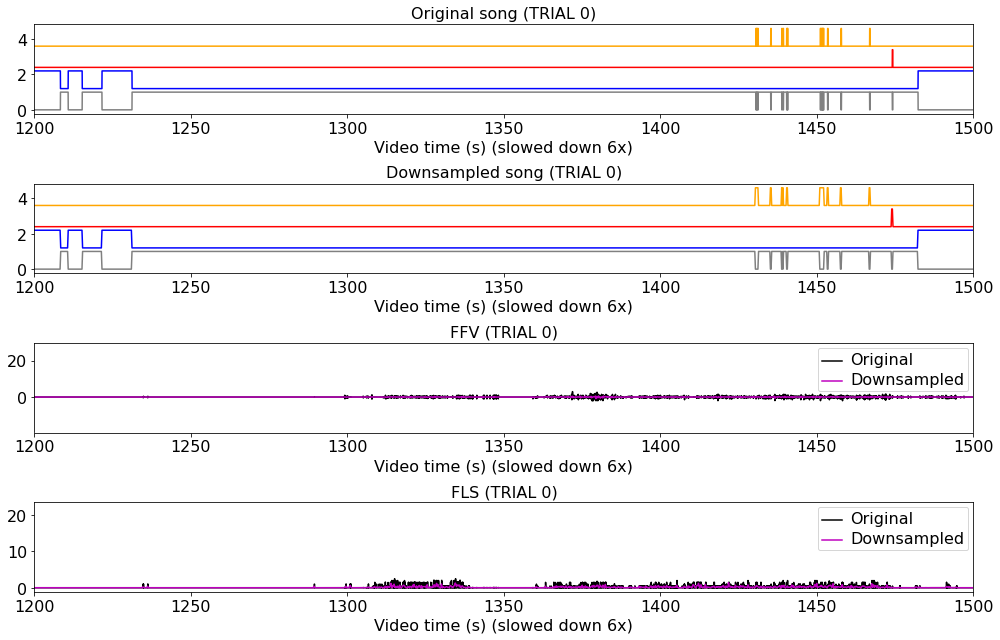

In [7]:
ctr = 0
fig, axs = plt.subplots(4, 1, figsize=(14, 9), tight_layout=True)

t_up = dfs_tr_up[ctr]['T']
q_up = dfs_tr_up[ctr]['Q']
s_up = dfs_tr_up[ctr]['S']
p_up = dfs_tr_up[ctr]['P']
f_up = dfs_tr_up[ctr]['F']

ffv_up = dfs_tr_up[ctr]['FFV']
fls_up = dfs_tr_up[ctr]['FLS']

t_dn = dfs_tr_dn_reloaded[ctr]['T']
q_dn = dfs_tr_dn_reloaded[ctr]['Q']
s_dn = dfs_tr_dn_reloaded[ctr]['S']
p_dn = dfs_tr_dn_reloaded[ctr]['P']
f_dn = dfs_tr_dn_reloaded[ctr]['F']

ffv_dn = dfs_tr_dn_reloaded[ctr]['FFV']
fls_dn = dfs_tr_dn_reloaded[ctr]['FLS']

axs[0].plot(t_up*6, q_up, color='gray')
axs[0].plot(t_up*6, s_up+1.2, color='b')
axs[0].plot(t_up*6, p_up+2.4, color='r')
axs[0].plot(t_up*6, f_up+3.6, color='orange')
axs[0].set_title(f'Original song (TRIAL {ctr})')

axs[1].plot(t_dn*6, q_dn, color='gray')
axs[1].plot(t_dn*6, s_dn+1.2, color='b')
axs[1].plot(t_dn*6, p_dn+2.4, color='r')
axs[1].plot(t_dn*6, f_dn+3.6, color='orange')
axs[1].set_title(f'Downsampled song (TRIAL {ctr})')

axs[2].plot(t_up*6, ffv_up, c='k')
axs[2].plot(t_dn*6, ffv_dn, c='m')
axs[2].set_title(f'FFV (TRIAL {ctr})')
axs[2].legend(['Original', 'Downsampled'])

axs[3].plot(t_up*6, fls_up, c='k')
axs[3].plot(t_dn*6, fls_dn, c='m')
axs[3].set_title(f'FLS (TRIAL {ctr})')
axs[3].legend(['Original', 'Downsampled'])

for ax in axs:
    ax.set_xlim(1200,1500)
    set_plot(ax, x_label='Video time (s) (slowed down 6x)', font_size=16)